# CNN Modeli - Transfer Learning

**Ad:** Muhammet  
**Soyad:** KABACALI  
**No:** 2112729007  
**GitHub:** https://github.com/MuhammetK315/Proje1_CNNN.git

---

## 1. Gerekli Kütüphaneleri İçe Aktar

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

print("Kütüphaneler başarıyla yüklendi.")

Kütüphaneler başarıyla yüklendi.


## 2. Veri Setini Yükleme ve Hazırlama

In [18]:
# Veri seti yolunun tanımlanması
dataset_path = 'dataset'
img_size = 224  # VGG16 için 224x224 önerilir
batch_size = 32

# Sınıfları al
classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)
print(f"Sınıflar: {classes}")
print(f"Sınıf sayısı: {num_classes}")

# Görüntüleri yükle
images = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png', '.JPG', '.PNG')):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = load_img(img_path, target_size=(img_size, img_size))
                    img_array = img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Hata: {img_path} - {e}")

images = np.array(images)
labels = np.array(labels)

print(f"\nToplam görüntü sayısı: {len(images)}")
print(f"Görüntü şekli: {images[0].shape}")

Sınıflar: ['class1', 'class2']
Sınıf sayısı: 2

Toplam görüntü sayısı: 100
Görüntü şekli: (224, 224, 3)


## 3. Veri Setini Eğitim ve Test Setlerine Böl

In [19]:
# %80 eğitim, %20 test
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# Etiketleri one-hot encode et
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

Eğitim seti boyutu: (80, 224, 224, 3)
Test seti boyutu: (20, 224, 224, 3)


## 4. Transfer Learning Modeli Oluştur (VGG16 ile Fine-tuning)

**Açıklama:** 
- ImageNet ağırlıklarından başlayarak önceden eğitilmiş bir model kullanıyoruz
- Son katmanları kendi veri setimize göre ince ayar (fine-tuning) yapıyoruz
- Bu yaklaşım daha az veri ile daha iyi performans sağlar

In [20]:
# VGG16 modelini ImageNet ağırlıklarıyla yükle
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# İlk katmanları dondur (transfer learning)
base_model.trainable = False

# Yeni sınıflandırma katmanlarını ekle - DAHA GÜÇLÜ Regularization ile
from tensorflow.keras.regularizers import l2

inputs = keras.Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)  # L2: 0.001 → 0.005
x = Dropout(0.5)(x)  # Dropout: 0.4 → 0.5
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)  # L2: 0.001 → 0.005
x = Dropout(0.5)(x)  # Dropout: 0.4 → 0.5
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Modeli derle - daha düşük learning rate ile
model.compile(
    optimizer=Adam(learning_rate=0.0003),  # Learning rate: 0.0005 → 0.0003 (daha yavaş)
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model oluşturuldu ve derlenmiştir.")
print("\n" + "="*60)
print("MODEL1 GÜÇLENDIRILMIŞ REGULARIZATION (Overfitting Engelleme)")
print("="*60)
print("✓ L2 Regularization: 0.001 → 0.005 (2.5x artış)")
print("✓ Dropout: 0.4 → 0.5 (daha fazla devre dışı bırakma)")
print("✓ Learning rate: 0.0005 → 0.0003 (daha yavaş eğitim)")
print("✓ Data Augmentation: Eğitim sırasında uygulanacak")
print("="*60)
model.summary()

Model oluşturuldu ve derlenmiştir.

MODEL1 GÜÇLENDIRILMIŞ REGULARIZATION (Overfitting Engelleme)
✓ L2 Regularization: 0.001 → 0.005 (2.5x artış)
✓ Dropout: 0.4 → 0.5 (daha fazla devre dışı bırakma)
✓ Learning rate: 0.0005 → 0.0003 (daha yavaş eğitim)
✓ Data Augmentation: Eğitim sırasında uygulanacak


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,170 (56.76 MB)

 Trainable params: 164,482 (642.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 5. Modeli Eğit

In [21]:
epochs = 100
batch_size = 32

# Early Stopping - Overfitting'i önlemek için
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,  # patience 5 → 8 artırıldı
    restore_best_weights=True,
    verbose=1
)

# Data Augmentation - Overfitting'i engellemek için ÇOOOK önemli
train_datagen = ImageDataGenerator(
    rotation_range=20,          # ±20 derece döndür
    width_shift_range=0.15,     # ±15% yatay kaydır
    height_shift_range=0.15,    # ±15% dikey kaydır
    horizontal_flip=True,       # Yatay çevir
    zoom_range=0.2,             # %20 zoom
    shear_range=0.15,           # Eğilti uygula
    fill_mode='nearest'
)

# Eğitim verisine augmentation uygulanıyor
train_datagen.fit(X_train)

# Augmented veri ile eğit
history = model.fit(
    train_datagen.flow(X_train, y_train_encoded, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test_encoded),  # Test seti olarak doğrulama yap
    callbacks=[early_stop],
    steps_per_epoch=len(X_train) // batch_size,
    verbose=1
)

print("\nModel eğitimi tamamlanmıştır.")
print(f"Toplam çalışan epoch sayısı: {len(history.history['loss'])}")
print("\n" + "="*60)
print("Data Augmentation Teknikleri Uygulandı:")
print("="*60)
print("✓ Rotation: ±20 derece")
print("✓ Width/Height Shift: ±15%")
print("✓ Horizontal Flip: Evet")
print("✓ Zoom: 0-20%")
print("✓ Shear: 15%")
print("="*60)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 3.2872 - val_accuracy: 1.0000 - val_loss: 3.1252
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 934ms/step - accuracy: 0.3750 - loss: 3.3158 - val_accuracy: 1.0000 - val_loss: 3.0922
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6458 - loss: 3.1770 - val_accuracy: 1.0000 - val_loss: 3.0301
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 938ms/step - accuracy: 0.5938 - loss: 3.1523 - val_accuracy: 1.0000 - val_loss: 2.9983
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5208 - loss: 3.2009 - val_accuracy: 1.0000 - val_loss: 2.9335
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 940ms/step - accuracy: 0.6562 - loss: 3.0469 - val_accuracy: 1.0000 - val_loss: 2.9020
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.5625 - loss: 3.0706 - val_accuracy: 1.0000 - val_loss: 2.8387
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 954ms/step - accuracy: 0.8125 - loss: 2.9541 - val_accuracy: 1.0000 - val_loss: 2.8

## 6. Eğitim Doğruluk ve Kayıp Grafiklerini Çiz

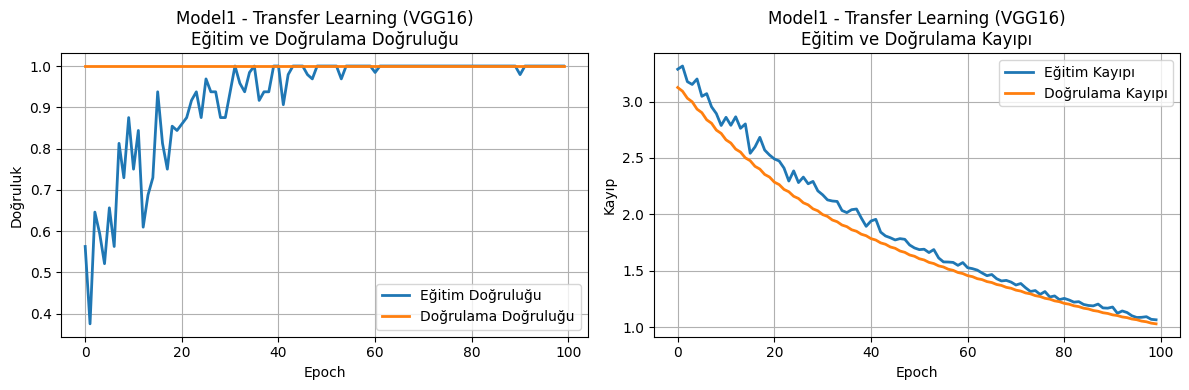

In [22]:
# Doğruluk grafiği
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.title('Model1 - Transfer Learning (VGG16)\nEğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.grid(True)

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kayıpı', linewidth=2)
plt.plot(history.history['val_loss'], label='Doğrulama Kayıpı', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Model1 - Transfer Learning (VGG16)\nEğitim ve Doğrulama Kayıpı')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Test Seti Doğruluğunu Değerlendir

In [23]:
# Test seti üzerinde değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

print("\n" + "="*50)
print("MODEL 1 - TRANSFER LEARNING (VGG16) SONUÇLARI")
print("="*50)
print(f"Test Seti Kayıpı: {test_loss:.4f}")
print(f"Test Seti Doğruluğu: {test_accuracy*100:.2f}%")
print("="*50)

# Detaylı metrikler
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=classes))

print("\nKonfüzyon Matrisi:")
print(confusion_matrix(y_test, y_pred))


MODEL 1 - TRANSFER LEARNING (VGG16) SONUÇLARI
Test Seti Kayıpı: 1.0288
Test Seti Doğruluğu: 100.00%

Sınıflandırma Raporu:
              precision    recall  f1-score   support

      class1       1.00      1.00      1.00        10
      class2       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


Konfüzyon Matrisi:
[[10  0]
 [ 0 10]]


## 8. Modeli Kaydet

In [24]:
model.save('model1_transfer_learning.h5')
print("Model başarıyla kaydedilmiştir: model1_transfer_learning.h5")

Model başarıyla kaydedilmiştir: model1_transfer_learning.h5
